---
title: "Gathering ancillary data for the Coiba POC"
author: "Cristian Correa"
date: "`r Sys.Date()`"
output: 
  html_document:
    code_fold: true
engine: knitr
---

**Table of contents**<a id='toc0_'></a>    
- [Libraries](#toc1_)    
- [Import data](#toc2_)    
  - [Import sample data (sample_data)](#toc2_1_)    
  - [Define map extent (area of interest)](#toc2_2_)    
    - [Sampling dates](#toc2_2_1_)    
- [Geographic coordinates](#toc3_)    
- [Copernicus Marine Service](#toc4_)    
  - [Net Primary Production](#toc4_1_)    
    - [Extract values from buffer zone](#toc4_1_1_)    
- [GIF animation from Copernicus Marine Service data](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

<!-- For more details on using R Markdown see <http://rmarkdown.rstudio.com>. -->

# <a id='toc1_'></a>[Libraries](#toc0_)

In [ ]:
#| message = FALSE
R.version
rm(list = ls())
library(tidyr)
library(dplyr)
library(ggplot2)
library(ncdf4) # for *.nc files
library(raster)
library(ggmap)
library(viridis)

               _                                
platform       x86_64-w64-mingw32               
arch           x86_64                           
os             mingw32                          
crt            ucrt                             
system         x86_64, mingw32                  
status                                          
major          4                                
minor          4.1                              
year           2024                             
month          06                               
day            14                               
svn rev        86737                            
language       R                                
version.string R version 4.4.1 (2024-06-14 ucrt)
nickname       Race for Your Life               

Warning message:
"package 'tidyr' was built under R version 4.4.3"
Warning message:
"package 'dplyr' was built under R version 4.4.3"

Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'ggplot2' was built under R version 4.4.3"
Warning message:
"package 'raster' was built under R version 4.4.3"
Loading required package: sp

Warning message:
"package 'sp' was built under R version 4.4.3"

Attaching package: 'raster'


The following object is masked from 'package:dplyr':

    select


Warning message:
"package 'ggmap' was built under R version 4.4.3"
ℹ Google's Terms of Service: <https://mapsplatform.google.com>
  Stadia Maps' Terms of Service: <https://stadiamaps.com/terms-of-service/>
  OpenStreetMap's Tile Usage Policy: <https://operations.osmfoundation.org/policies/tiles/>
ℹ Please cite ggmap if you use it! Use

In this document and script, various data sources offering worldwide remote-sensing data were queried to retrieve physical and biogeochemical variables with potential predictive power for biodiversity.  


In [ ]:
setwd("C:/Users/crist/Documents/GitHub/Copernicus_downloader_Coiba/Copernicus_downloader")

# <a id='toc2_'></a>[Import data](#toc0_)


## <a id='toc2_1_'></a>[Import sample data (sample_data)](#toc0_)
Provide a table with sample sites on rows and attributes on columns. 

In [ ]:
# Import sample data

# (If unavailable, generate a table with site_code, lon, lat, and other attributes  
# useing the Sampling_Planner_App)

sample_data <- read.csv("zone_coords_Coiba.csv") 

# Rename columns
sample_data <- sample_data %>%
  rename(
    site_code = zone,
    lon = Longitude,
    lat = Latitude)
head(sample_data)


,site_code,lat,lon,zone_selection_plankton,zone_selection_eDNA,zone_selection_eDNA2,zone_selection_sediment,zone_selection_sediment2,Comments
,<chr>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
1,Z1,7.630140,-81.72629,FALSE,TRUE,FALSE,FALSE,TRUE,NA
2,Z2,7.416942,-82.14752,FALSE,TRUE,FALSE,FALSE,TRUE,NA
3,Z3,7.606192,-81.58722,FALSE,TRUE,FALSE,FALSE,TRUE,NA


## <a id='toc2_2_'></a>[Define map extent (area of interest)](#toc0_)

In [ ]:
extent1 <- make_bbox(data = sample_data, lon = lon, lat = lat) 
# extent <- extent(-85, -78, 5, 10)
extent2 <- data.frame(lon = c(-85, -78), 
                        lat = c(5, 10))


### <a id='toc2_2_1_'></a>[Sampling dates](#toc0_)

In [ ]:
# sample_data$SamplingDate <- as.Date(sample_data$Collection_Date)

daterange <- c("2015-01-01", "2025-03-01") %>% as.Date()

# <a id='toc3_'></a>[Geographic coordinates](#toc0_)

Identify unique sets of coordinates and average by site if necessary

In [ ]:
# Unique coordinates
coords <- sample_data %>% reframe(lat = unique(lat), lon = unique(lon))
coords

lat,lon
<dbl>,<dbl>
7.630140,-81.72629
7.416942,-82.14752
7.606192,-81.58722


Check geographic coordinates and identify potential problems. It may be useful to plot and label the mean site_code of stationary monitoring stations (e.g., temporal sampling in the same bay). In addition, plot the original geographic coordinates, and connect with edges  sites under the same site label (all coordinates under the same site label should be close to each other).

In [ ]:
library(ggmap)

# Average coordinates per site 
centroids <- sample_data %>% 
  group_by(site_code) %>%  
  summarise(lon = mean(lon), lat=mean(lat))

# Unique coordinates per site
tmp2 <- sample_data %>% 
  group_by(site_code) %>%  
  distinct(lon, lat)

# Set bounding box 
# bbox <- make_bbox(centroids$lon, centroids$lat, f = c(0.3,0.3)) # only works with a range of coordinates

bbox <- round(
  make_bbox(mean(centroids$lon) + c(-2, 4),
            mean(centroids$lat) + c(-1.5, 2))
              , 2)

# bbox <- make_bbox(extent2$lon, extent2$lat) 

cat("Bounding box: ", bbox, "\n")

register_stadiamaps(key = "f4aaa648-6137-4e34-a850-46c9821d7a6a")
map <- ggmap(get_stadiamap(bbox = bbox, zoom = 7, maptype = "stamen_terrain_background"))

Bounding box:  -84.12 5.88 -77.52 9.73 


ℹ © Stadia Maps © Stamen Design © OpenMapTiles © OpenStreetMap contributors.



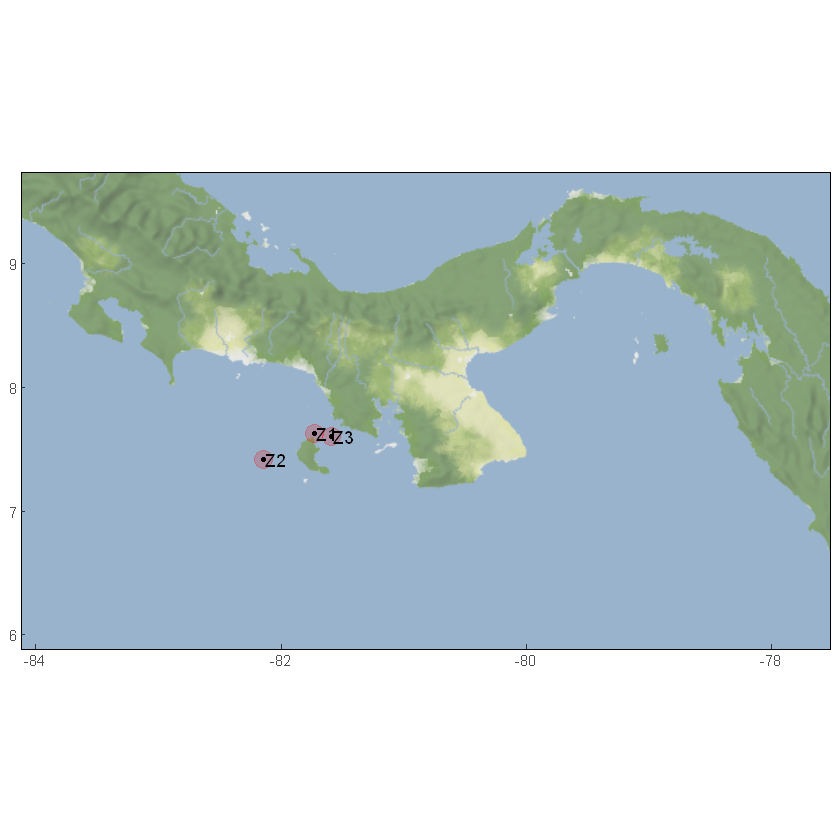

In [ ]:
#| echo: false
#| fig-width: 12
#| fig-height: 6

# grDevices::png("Map.png", 600, 1200, res = 300)
map + 
  geom_point(data = centroids, aes(x = lon, y = lat), color = "red", size = 5, alpha=0.2)+
  geom_text(data = centroids, aes(x = lon, y = lat, label=site_code,hjust=-0.1))+ # 
  geom_point(data = tmp2, aes(x = lon, y = lat), size=1, alpha = 1)+ # , color=site_code
  # create a star-like (ordispider) effect for each group
  # geom_segment(data = tmp2, aes(x = long_e, y = lat_n, 
  #                 xend = centroids$lon[match(site_code, centroids$site_code)], 
  #                 yend = centroids$lat[match(site_code, centroids$site_code)], 
  #                 color=site_code), size=0.5) + 
  # annotate("text", x=-Inf, y=c(-37, -45), label=c(expression(text="37"*degree*"S"),expression("45"*degree*"S")), hjust=-0.2,size=3)+
  # scale_y_continuous(breaks = c(-37,-45), labels = NULL, expand = c(0,0))+
  # scale_x_continuous(breaks = NULL, labels = NULL, expand = c(0,0))+
  # scale_color_continuous()+
  scale_color_brewer(palette = "Spectral")+
  theme(axis.ticks.length=unit(-1, "mm"), 
      panel.border = element_rect(colour = "black", linewidth=0.5, fill=NA),
      axis.title = element_blank())

# dev.off()


Once the map area is defined, it is possible to query remote sensing data sources to retrieve physical and biogeochemical variables. The bounding box of the map area can be used to query data from different sources.   

The bounding box coordinates are:
- **Left (min longitude):** `r bbox[1]`
- **Bottom (min latitude):** `r bbox[2]`
- **Right (max longitude):** `r bbox[3]`
- **Top (max latitude):** `r bbox[4]`

Can also `r dput(bbox)` to print the bounding box coordinates.

In [ ]:
dput(bbox)

c(left = -84.12, bottom = 5.88, right = -77.52, top = 9.73)


In [10]:
ls()

[1] "bbox"        "centroids"   "coords"      "daterange"   "extent1"    
[6] "extent2"     "map"         "sample_data" "tmp2"

# <a id='toc4_'></a>[Copernicus Marine Service](#toc0_)

Copernicus Marine presents one of the largest data inventories of high-quality ocean data. The Copernicus Marine Service (or Copernicus Marine Environment Monitoring Service) is the marine component of the Copernicus Programme of the European Union. It provides free, regular and systematic authoritative information on the state of the Blue (physical), White (sea ice) and Green (biogeochemical) ocean,  on a global and regional scale.   It is funded by the European Commission (EC) and implemented by Mercator Ocean International [https://data.marine.copernicus.eu/products](https://data.marine.copernicus.eu/products).

There are a few options to download the data:

1) Downloaded using spatial, temporal, depth, etc., filters directly from the webpage [https://data.marine.copernicus.eu/products](https://data.marine.copernicus.eu/products). Then, the files can be further processed here. 

2) There is a Phython API called `copernicusmarine` that can be used to mass-download data. Follows a Python script to download time series in bulk (adapted from `Copernicus_data_download.py` which I stored on Github).

Some of the libraries were installed in a virtual environment for this test project. Therefore, before running this jupyter notebook, activate the virtual environment like this:  

in bash, navigate to the project's folder where the .venv is and run

.venv\Scripts\Activate.ps1

Once the virtual environment is activated, run the 
jupyter notebook

and select the right kernel called 
"Python (Copernicus Downloader)"

In case the latter isn't registered, register a new jupyter kernel (this might be done already). 
pip install ipykernel
python -m ipykernel install --user --name=coiba_env --display-name "Python (Copernicus Downloader)"




In [ ]:
##################################
#
# Mass-download Copernicus data sets for time series 
# Cristian Correa, March 2025.
# Requires Phython >3.9
#
#################################

import os
os.chdir("./Copernicus_NPP/")
os.getcwd()

'C:\\Users\\crist\\Documents\\GitHub\\Copernicus_downloader_Coiba\\Copernicus_downloader\\Copernicus_NPP'

In [ ]:
# Clear all variables from the current environment
for name in dir():
    if not name.startswith('_'):
        del globals()[name]

In [1]:
import sys
print(sys.executable)

C:\Users\crist\miniconda3\python.exe


In [ ]:
import os
import copernicusmarine
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime, timedelta

In [ ]:
# User credentials
user_ = "ccorrea"
pass_ = "Galax1as"

Next, specify a dataset. Datasets can be found https://data.marine.copernicus.eu/products. Use filters to narrow down the search (e.g., by date range) > choose Product > Data access > Dateset (table) > Form (under Subset column).

Go to Automate tab > Phython API. There you will find an snippet that can be modified and used to download the desired data. 


In [ ]:
dataset_id = "cmems_mod_glo_bgc_my_0.083deg-lmtl_PT1D-i"  
dataset_version = "202411"
variables = ["npp"]
output_dir = "Copernicus_NPP"

Get the geographical coordinates of the bounding box and the time range of interest. 

In [ ]:

# Define geographic extent
# longitude_bounds = (-122, -121)
# latitude_bounds = (36, 37)

# longitude_bounds = (-122.431, -121.771)
# latitude_bounds = (36.285, 37.385)

longitude_bounds = (-84.12, -77.52)
latitude_bounds = (5.88, 9.73)


In [ ]:

# Define date range (daily intervals)
start_date = datetime(2015, 1, 26)
end_date = datetime(2016, 12, 31)
date_range = [start_date + timedelta(days=i) for i in range((end_date - start_date).days + 1)]


In [ ]:

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Loop over each date (daily downloads)
for date in date_range:
    # Define start and end times (one-day period)
    start_str = date.strftime("%Y-%m-%dT00:00:00")
    end_str =  date.strftime("%Y-%m-%dT23:59:59")
    
    # Define output filename for this day
    output_filename = f"nppv_{date.strftime('%Y%m%d')}.nc"
    output_path = os.path.join(output_dir, output_filename)
    
    # Skip download if the file already exists
    if os.path.exists(output_path):
        print(f"File {output_filename} already exists, skipping download.")
        continue

    # Download data for this day
    try:
        response = copernicusmarine.subset(
            dataset_id=dataset_id,
            dataset_version=dataset_version,
            variables=variables,
            minimum_longitude=longitude_bounds[0],
            maximum_longitude=longitude_bounds[1],
            minimum_latitude=latitude_bounds[0],
            maximum_latitude=latitude_bounds[1],
            start_datetime=start_str,
            end_datetime=end_str,
            coordinates_selection_method="strict-inside",
            minimum_depth=0,
            maximum_depth=10,
            disable_progress_bar=False,
            username=user_,
            password=pass_
        )

        # Ensure the response contains a file path
        if hasattr(response, "file_path") and os.path.exists(response.file_path):
            os.rename(response.file_path, output_path)
            print(f"Saved daily data for {start_str} as {output_filename}")
        else:
            print(f"Download failed or file not found for {start_str}")

    except Exception as e:
        print(f"Error downloading data for {start_str}: {e}")



In [ ]:

# The forlder is populated by *.nc files (one per date in the time series).

# Get a description of the data set 
catalogue = copernicusmarine.describe(dataset_id = "cmems_mod_glo_bgc_my_0.083deg-lmtl_PT1D-i")
# Filter the output
catalogue_dict = catalogue.model_dump(
    exclude_none=True, 
    exclude_unset=True, 
    exclude={"products": {"__all__": {"datasets": True, "description": True, "keywords": True}}}
    )
catalogue_dict["products"][0]

Fetching catalogue:  50%|███████████████████████████████████████████████████▌                                                   | 1/2 [00:03<00:03,  3.40s/it]

{'title': 'Global ocean low and mid trophic levels biomass content hindcast',
 'product_id': 'GLOBAL_MULTIYEAR_BGC_001_033',
 'thumbnail_url': 'https://mdl-metadata.s3.waw3-1.cloudferro.com/metadata/thumbnails/GLOBAL_MULTIYEAR_BGC_001_033.jpg',
 'digital_object_identifier': '10.48670/moi-00020',
 'sources': ['Numerical models'],
 'processing_level': 'Level 4',
 'production_center': 'Mercator Océan International'}



## <a id='toc4_1_'></a>[Net Primary Production](#toc0_)

A time series was downloaded using the `Copernicus_data_download.py` script.
Begin by examining one frame:

In [ ]:
#| message = FALSE
setwd("C:/Users/crist/Documents/GitHub/Copernicus_downloader_Coiba/Copernicus_downloader")

rm(list = ls())
library(tidyr)
library(dplyr)
library(ggplot2)
library(ncdf4) # for *.nc files
library(raster)
library(ggmap)
library(viridis)

Warning message:
"package 'tidyr' was built under R version 4.4.3"
Warning message:
"package 'dplyr' was built under R version 4.4.3"

Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'ggplot2' was built under R version 4.4.3"
Warning message:
"package 'raster' was built under R version 4.4.3"
Loading required package: sp

Warning message:
"package 'sp' was built under R version 4.4.3"

Attaching package: 'raster'


The following object is masked from 'package:dplyr':

    select


Warning message:
"package 'ggmap' was built under R version 4.4.3"
ℹ Google's Terms of Service: <https://mapsplatform.google.com>
  Stadia Maps' Terms of Service: <https://stadiamaps.com/terms-of-service/>
  OpenStreetMap's Tile Usage Policy: <https://operations.osmfoundation.org/policies/tiles/>
ℹ Please cite ggmap if you use it! Use

In [ ]:
# Set the path for the NetCDF file
ncfile <- "./Copernicus_NPP/Copernicus_NPP/Copernicus_NPP/nppv_20150126.nc"
# # Import NetCDF
 nc <- nc_open(ncfile)

  print(nc)

File ./Copernicus_NPP/Copernicus_NPP/Copernicus_NPP/nppv_20150126.nc (NC_FORMAT_NETCDF4):

     1 variables (excluding dimension variables):
        short npp[longitude,latitude,time]   (Contiguous storage)  
            _FillValue: -32767
            units: mg m-2 day-1
            standard_name: net_primary_productivity_of_biomass_expressed_as_carbon_in_sea_water
            add_offset: 7846.3802682577
            scale_factor: 0.239467138637724

     3 dimensions:
        time  Size:1 
            unit_long: Seconds Since 1970-01-01
            axis: T
            long_name: Time
            standard_name: time
            units: seconds since 1970-01-01
            calendar: standard
        latitude  Size:46 
            axis: Y
            units: degrees_north
            standard_name: latitude
        longitude  Size:79 
            axis: X
            units: degrees_east
            standard_name: longitude

    7 global attributes:
        references: http://www.cls.fr; http:

Import the nc file as a raster

class      : RasterLayer 
dimensions : 46, 79, 3634  (nrow, ncol, ncell)
resolution : 0.08333333, 0.08333332  (x, y)
extent     : -84.125, -77.54167, 5.874999, 9.708332  (xmin, xmax, ymin, ymax)
crs        : +proj=longlat +datum=WGS84 +no_defs 
source     : nppv_20150126.nc 
names      : npp 
z-value    : 2015-01-26 
zvar       : npp 


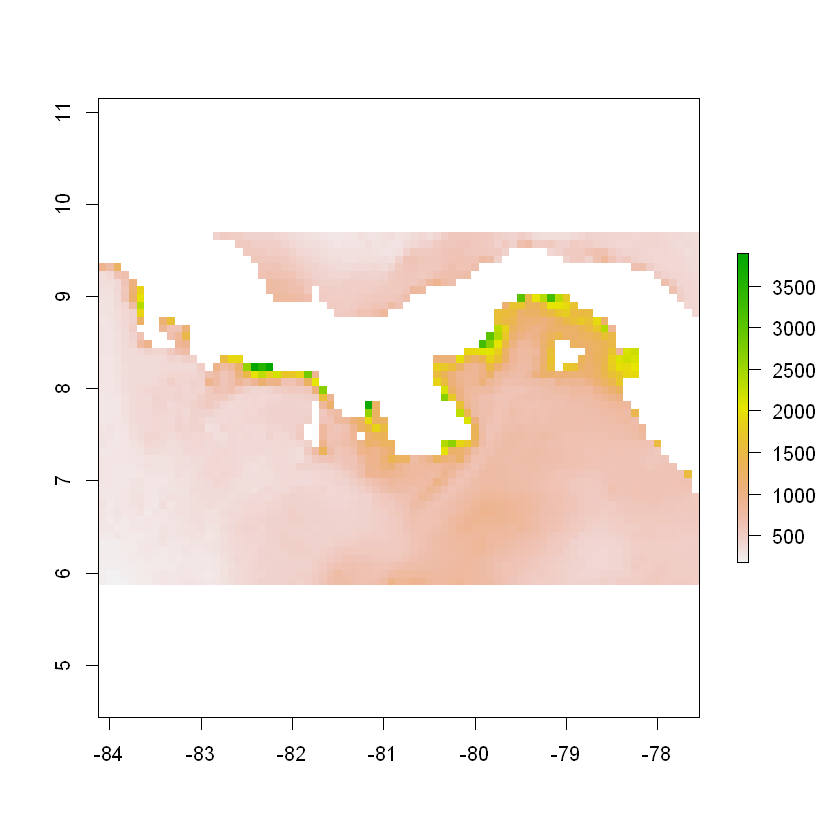

In [ ]:
# import NetCDF with raster
(npp <- raster::raster(ncfile))

plot(npp)

Plot one frame along with a reference map and sampling site(s).

In [ ]:
bbox <- c(left = -84.12, bottom = 5.88, right = -77.52, top = 9.73)
bbox_rect <- extent(bbox[1], bbox[3], bbox[2], bbox[4])


In [ ]:
# Load the raster file
npp <- raster(ncfile)

# Define the rectangle (bounding box) around the sampling site
bbox_rect <- data.frame(
  lon = as.vector(attributes(npp)$extent)[1:2],  # Longitude bounds
  lat = as.vector(attributes(npp)$extent)[3:4]  # Latitude bounds
)


In [ ]:
sample_data <- read.csv("zone_coords_Coiba.csv") 

# Rename columns
centroids <- sample_data %>%
  rename(
    site_code = zone,
    lon = Longitude,
    lat = Latitude) %>% dplyr::select(site_code, lon, lat) %>% 
    group_by(site_code) %>% 
    summarise(lon = mean(lon), lat = mean(lat))

centroids

site_code,lon,lat
<chr>,<dbl>,<dbl>
Z1,-81.72629,7.630140
Z2,-82.14752,7.416942
Z3,-81.58722,7.606192


ℹ © Stadia Maps © Stamen Design © OpenMapTiles © OpenStreetMap contributors.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.
Warning message:
"Removed 120 rows containing missing values or values outside the scale range (`geom_raster()`)."


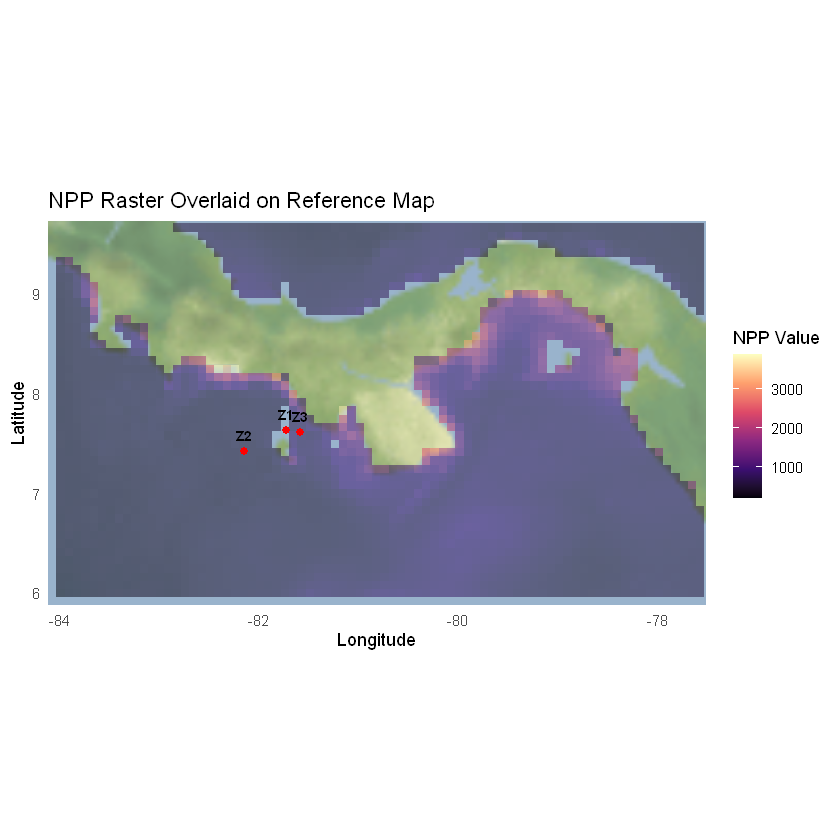

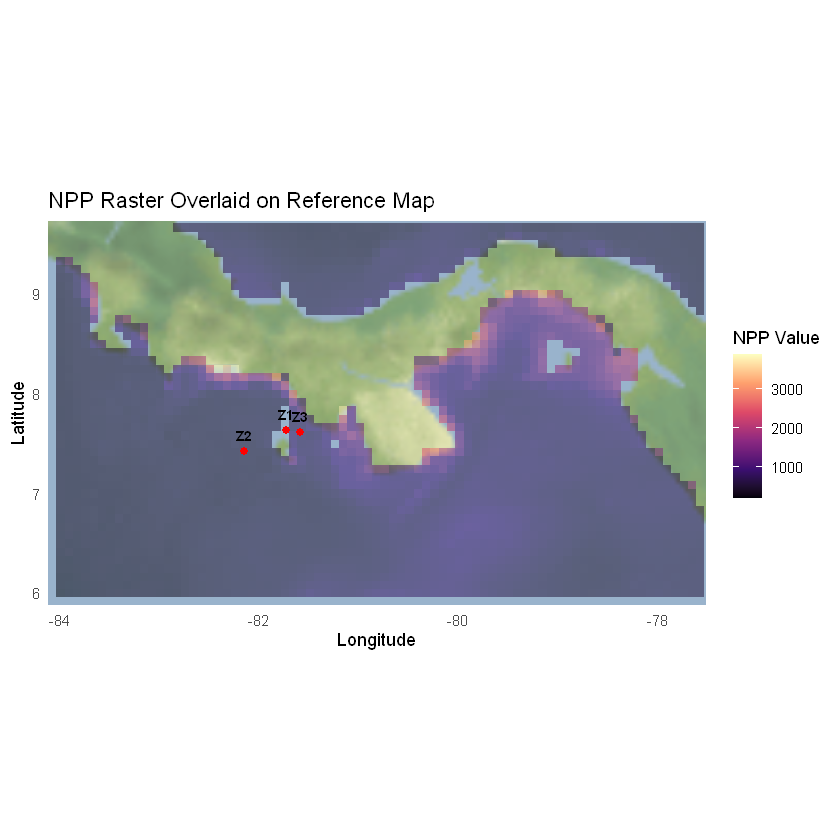

In [ ]:

# Convert raster to dataframe for ggplot2
npp_df <- as.data.frame(npp, xy = TRUE, na.rm = TRUE)
colnames(npp_df) <- c("lon", "lat", "value")

# Define Sampling Site (M0)
sampling_site <- centroids # data.frame(lon = -121.901, lat = 36.835, label = "M0")

# Compute bounding box
# centroids   # Adjust if you have more sites

# Register and fetch the map
register_stadiamaps(key = "f4aaa648-6137-4e34-a850-46c9821d7a6a")
map <- ggmap(get_stadiamap(bbox = bbox, zoom = 5, maptype = "stamen_terrain_background"))

# Combine the raster layer, background map, and sampling site
map <- map +
  geom_raster(data = npp_df, aes(x = lon, y = lat, fill = value), alpha = 0.5) +  # Semi-transparent raster
  scale_fill_viridis_c(option = "magma", na.value = "white") +  # Color scale for raster
  geom_point(data = sampling_site, aes(x = lon, y = lat), color = "red", size = 2) +  # Sampling site
  # geom_polygon(data = bbox_rect, aes(x = lon, y = lat), 
  #              fill = NA, color = "red", size = 1)+  
  geom_text(data = centroids, aes(x = lon, y = lat, label = site_code), vjust = -1, size = 3, fontface = "bold") +  
  coord_equal() +
  theme_minimal() +
  labs(title = "NPP Raster Overlaid on Reference Map", fill = "NPP Value", x = "Longitude", y = "Latitude")

map

### <a id='toc4_1_1_'></a>[Extract values from buffer zone](#toc0_)

Examine the possibility to extract grid values from a buffer zone. Define a buffer zone in case you want to use it. 

In [ ]:
# Load required packages
library(ggmap)
library(ggplot2)
library(sf)

buffer_meters <- 20000  # Radius in meters for extraction buffer

# Use original coordinates for extraction buffer or a nearby representative place
coords2 <- centroids[2,]
#coords2 <- data.frame(lon = -122, lat = 36.8) 

coords2

site_code,lon,lat
<chr>,<dbl>,<dbl>
Z2,-82.14752,7.416942


In [ ]:

# Convert the coordinates into an sf point object
coords_sf <- st_as_sf(coords2, coords = c("lon", "lat"), crs = 4326) 
# Transform to a projected CRS for proper distance measurement (meters)
coords_sf <- st_transform(coords_sf, crs = 3857)
# Create a circular buffer
buffer <- st_buffer(coords_sf, dist = buffer_meters)
# Transform back to lat/lon (WGS84) for plotting on ggmap
buffer <- st_transform(buffer, crs = 4326)


Coordinate system already present. Adding new coordinate system, which will replace the existing one.
Warning message:
"Removed 120 rows containing missing values or values outside the scale range (`geom_raster()`)."


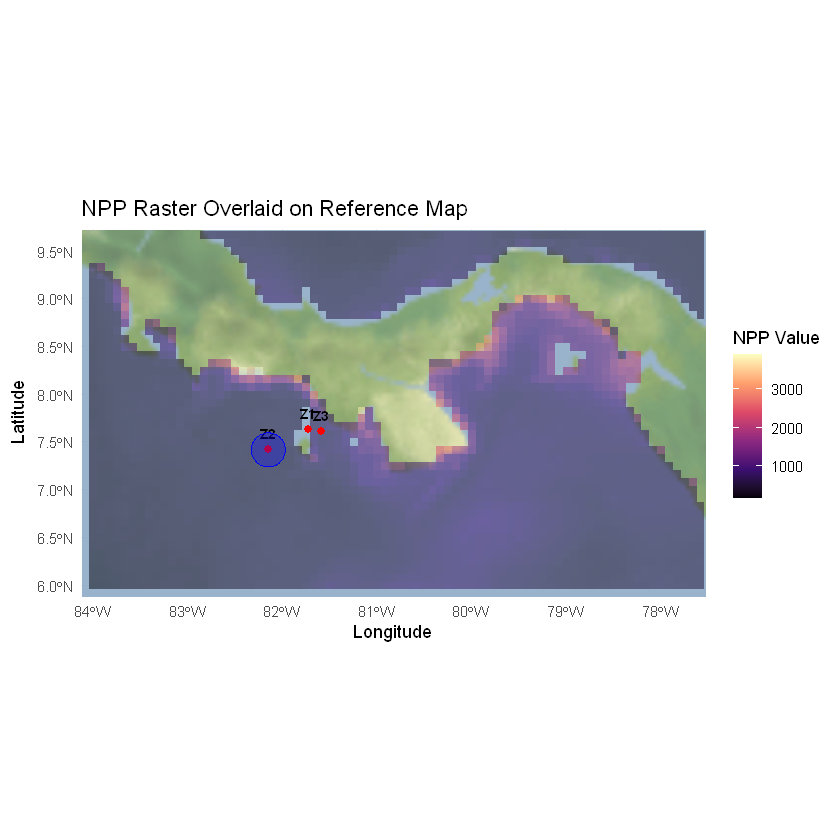

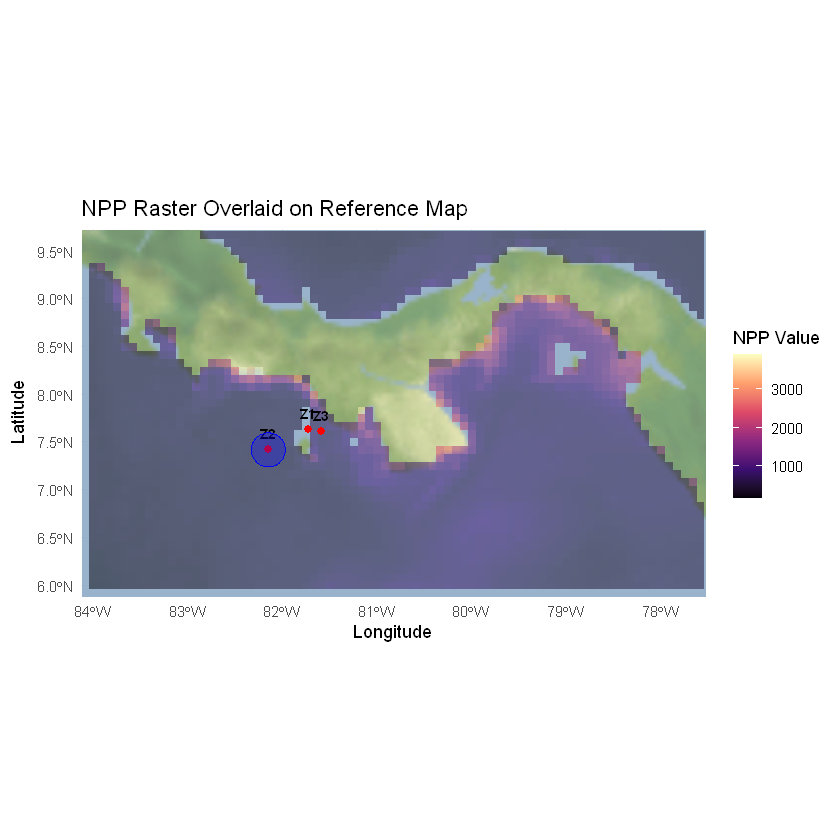

In [ ]:
#| echo: false
#| fig-width: 12
#| fig-height: 6
# options(echo = FALSE, repr.plot.width = 12, repr.plot.height = 6)

map  +
  geom_sf(data = buffer, inherit.aes = FALSE, fill = "blue", alpha = 0.3, color = "blue")

Based on the buffer zone selected, extract grid values for each time frame.
Extraction is done through `raster::extract` function. If argument `buffer` is used, all values contained within the buffer are returned, and if `fun` is provided in addition, all cell values are collapsed in one values (e.g., mean).  

In [ ]:
library(raster)
library(sf)

In [ ]:
# output_file <- "cmems_mod_glo_bgc_my_0.083deg-lmtl_PT1D-i__v202411.npp.tsv"

# Get list of NetCDF files
files <- list.files(path = "./Copernicus_NPP/Copernicus_NPP/Copernicus_NPP/",
                    pattern = "nppv_.*\\.nc$",  # \ escapes the .
                    full.names = TRUE)         # Get full paths


In [ ]:
# Function to extract the date from filenames
extract_date_from_filename <- function(filename) {
  match <- regexpr("nppv_(\\d{8})\\.nc$", basename(filename), perl = TRUE)
  if (match != -1) {
    date_str <- sub("nppv_(\\d{8})\\.nc$", "\\1", basename(filename))
    return(as.Date(date_str, format = "%Y%m%d"))  # Convert to Date format
  } else {
    return(NA)  # Return NA if no match is found
  }
}

In [ ]:
# Initialize output list
output_list <- list()

# Loop through files
for (file in files) {
  date <- extract_date_from_filename(file)
  npp <- raster(file)  # Load raster
  
  # Transform spatial points to match the CRS of the raster
  coords_sf_transformed <- st_transform(coords_sf, crs = crs(npp))
  
  # Extract values
  value <- raster::extract(x = npp, y = coords_sf_transformed, 
            buffer = buffer_meters, fun = mean, na.rm = TRUE, 
            small = FALSE, df = TRUE, weights = TRUE)[[2]]
  
  # Store results in a structured way
  output_list[[length(output_list) + 1]] <- data.frame(
    filename = basename(file),
    date = date,
    value = value
  )
}

# Combine results into a dataframe
output_df <- do.call(rbind, output_list)

In [ ]:
# Save as TSV file
write.table(output_df, file = output_file, sep = "\t", row.names = FALSE, quote = FALSE)

tail(output_df)

,filename,date,value
,<chr>,<date>,<dbl>
396,nppv_20160225.nc,2016-02-25,346.2845
397,nppv_20160226.nc,2016-02-26,409.4738
398,nppv_20160227.nc,2016-02-27,422.4649
399,nppv_20160228.nc,2016-02-28,531.0034
400,nppv_20160229.nc,2016-02-29,575.7239
401,nppv_20160301.nc,2016-03-01,404.3253


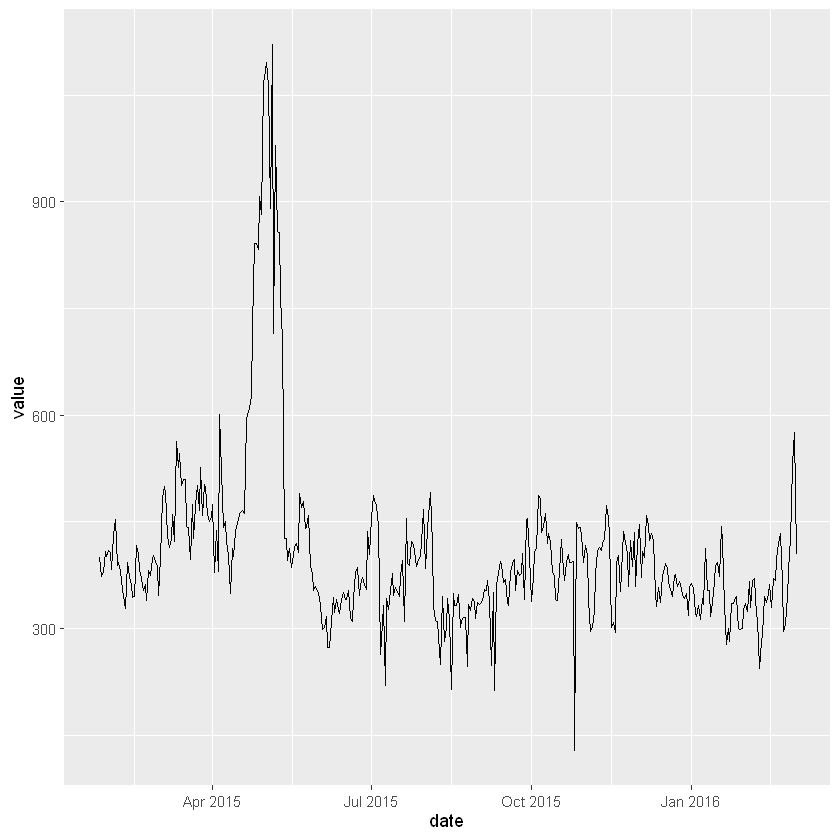

In [ ]:
#| echo: false
#| fig-width: 12
#| fig-height: 6

output_df %>% ggplot(aes(date, value))+
  geom_line()


# <a id='toc5_'></a>[GIF animation from Copernicus Marine Service data](#toc0_)
In this section, the raster frames downloaded in the previous section are transformed to *.png, and then packed into a *.gif animation.

In [3]:
from PIL import Image
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import imageio
import os
from matplotlib.patches import Circle

In [4]:
# Define geographic extent parameters (see output of dput() above to import values here)
longitude_bounds = (-84.12, -77.52)
latitude_bounds = (5.88, 9.73)

In [8]:
# Load the background image and get its dimensions for aspect ratio and exact sizing
background_path = "NAL Slide theme.png"  # Path to your background image
background = Image.open(background_path).convert("RGBA")
bg_width, bg_height = background.size

In [10]:
# Set DPI and calculate figure size based on the background image’s dimensions
dpi = 100
figsize = (bg_width / dpi, bg_height / dpi)

In [11]:
# Define proportional outer margin (10% on each side)
margin_ratio = 0.05  # 10% margin on all sides

In [13]:
# Folder paths
input_folder = "Copernicus_NPP"
output_gif = "nppv_time_series_with_background.gif"

In [43]:
# Initialize an empty list to store file paths for each frame
frames = []

# Loop through each NetCDF file in the imagery folder
for file_name in sorted(os.listdir(input_folder)):
    if file_name.endswith(".nc"):
        # Load the NetCDF file
        data_path = os.path.join(input_folder, file_name)
        ds = xr.open_dataset(data_path)

        # Select the first time step and a specific depth to create a 2D slice
        nppv = ds['npp'].isel(time=0)#.sel(depth=0.494, method="nearest")
        time_step = str(ds['time'].values[0])[:10]

        # Set up the figure with exact background dimensions and DPI
        fig = plt.figure(figsize=figsize, dpi=dpi)

        # Define the axes to center the plotting area and include the outer margin
        ax = plt.axes([
            margin_ratio, margin_ratio + 0.1,  # left and bottom to center the plot
            1 - 2 * margin_ratio, 1 - 2 * (margin_ratio + 0.1)  # width and height adjusted for top margin
        ], projection=ccrs.PlateCarree())
        
        ax.set_extent([longitude_bounds[0], longitude_bounds[1], latitude_bounds[0], latitude_bounds[1]], crs=ccrs.PlateCarree())

        # Add a hollow red circle around Bermuda
        #bermuda_lat = 32.3
        #bermuda_lon = -64.8
        #circle_radius = 1  # degrees
        #circle = Circle((bermuda_lon, bermuda_lat), circle_radius, transform=ccrs.PlateCarree(),
         #               edgecolor="red", facecolor="none", linewidth=2)
        #ax.add_patch(circle)

        # Plot the 2D nppv slice without a color bar, setting limits for consistent scaling
        img = nppv.plot.imshow(ax=ax, cmap="viridis", 
                               vmin=0, 
                               vmax=800, 
                               add_colorbar=False, add_labels=False, transform=ccrs.PlateCarree())

        # Add solid black landmasses without borders
        ax.add_feature(cfeature.LAND, facecolor='black')

        # Customize plot title and labels with specified color
        title_color = "#d3ff22ff"
        ax.set_title(f"{time_step}", fontsize=40, color=title_color, loc="right")

        # Position color bar adjacent to the plotting area, respecting the outer margin
        cbar_ax = fig.add_axes([
            margin_ratio + 0.15, margin_ratio + 0.05,  # slightly below the plot area
            1 - 2 * (margin_ratio + 0.15), 0.03  # set width and height, keeping the margin
        ])
        
        cbar = fig.colorbar(img, cax=cbar_ax, orientation="horizontal", ticks=[0, 200, 400, 600, 800])
        cbar.set_label("Carbon concentration (mg m$^{-3}$ day$^{-1}$)", color=title_color, fontsize=30)
        cbar.ax.tick_params(colors=title_color, labelsize=20)
        
        # Save the plot with a transparent background, removing extra padding
        frame_path = os.path.join(input_folder, f"{time_step}.png")
        plt.savefig(frame_path, transparent=True) #, bbox_inches="tight", pad_inches=0
        plt.close(fig)

        # Open the saved frame and overlay it on the background
        frame = Image.open(frame_path).convert("RGBA")

        # Resize background to match the frame’s size if necessary
        background_resized = background.resize(frame.size)

        # Calculate offsets to center the frame on the background
        offset_x = (background_resized.width - frame.width) // 2
        offset_y = (background_resized.height-100 - frame.height) // 2

        # Create a new image by pasting the frame onto the centered position of the background
        combined = Image.new("RGBA", background_resized.size)
        combined.paste(background_resized, (0, 0))  # Place background
        combined.paste(frame, (offset_x, offset_y), mask=frame)  # Center the frame on the background

        combined_path = os.path.join(input_folder, f"combined_{time_step}.png")
        combined.save(combined_path)  # Save combined image

        # Add the combined frame to the list
        frames.append(combined_path)

# Create the GIF with the combined frames
with imageio.get_writer(output_gif, mode="I", fps=12, loop=0) as writer:
    for frame_path in frames:
        image = imageio.imread(frame_path)
        writer.append_data(image)


# del image  # Free up the memory used by `image`

# Clean up individual frames (optional)
# for frame_path in frames:
#     os.remove(frame_path)

print(f"GIF saved as {output_gif}")

C:\Users\crist\AppData\Local\Temp\ipykernel_26140\3541563474.py:86: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame_path)


GIF saved as nppv_time_series_with_background.gif


Note that more sophisticated analyses and visualizations are possible, such and animation of particle advection using ocean currents. 
Parcels (short for Parcel Lagrangian Ocean Analysis) is a powerful Python library specifically designed to simulate particle movement in ocean flow fields. It’s perfect for visualizing drifters, plankton, pollution, larvae dispersal, etc., using oceanographic data like the one downloaded from Copernicus Marine Services. 